In [1]:
import pandas as pd
from src.utils.timescaledb_ops import TimescaleDBOps

# Technical Analysis and Chart

In [2]:
tsdb_ops = TimescaleDBOps()
columns, data = tsdb_ops.read_data("silver.ohlc_daily")
# columns, data = tsdb_ops.read_data("silver.ohlc_weekly")
# columns, data = tsdb_ops.read_data("silver.ohlc_monthly")
df = pd.DataFrame(data=data, columns=columns)
df = df.sort_values("date").reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

2025-06-25 21:24:05,646 - INFO - Data read from silver.ohlc_daily successfully.


In [3]:
df.head()

,date,pair,open,high,low,close,volume,count
0,2013-10-07,XXBTZUSD,122.00000,122.00000,122.00,122.00,15.0,0
1,2013-10-08,XXBTZUSD,122.00000,124.19000,122.00,124.18,34.0,20
2,2013-10-09,XXBTZUSD,124.19000,124.19000,123.84,123.84,51.0,50
3,2013-10-10,XXBTZUSD,124.01687,124.01687,123.84,123.84,72.0,66
4,2013-10-11,XXBTZUSD,124.01687,125.86000,123.84,125.86,55.0,53


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4280 entries, 0 to 4279
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4280 non-null   datetime64[ns]
 1   pair    4280 non-null   object        
 2   open    4280 non-null   float64       
 3   high    4280 non-null   float64       
 4   low     4280 non-null   float64       
 5   close   4280 non-null   float64       
 6   volume  4280 non-null   float64       
 7   count   4280 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 267.6+ KB


In [5]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# def plot_ohlcv(df: pd.DataFrame, title: str = "OHLCV Chart"):
#     """
#     Plots OHLCV data using Plotly with candlestick and volume subplot.

#     Parameters:
#     - df (pd.DataFrame): DataFrame with ['date', 'open', 'high', 'low', 'close', 'volume']
#     - title (str): Title for the chart
#     """

#     # Validate required columns
#     required_cols = {'date', 'open', 'high', 'low', 'close', 'volume'}
#     if not required_cols.issubset(df.columns):
#         raise ValueError(f"DataFrame must contain columns: {required_cols}")

#     # Ensure datetime is in correct format
#     df['date'] = pd.to_datetime(df['date'])

#     # Create subplot with 2 rows (OHLC and Volume)
#     fig = make_subplots(rows=4, cols=1, 
#                         shared_xaxes=True, 
#                         vertical_spacing=0.02,
#                         row_heights=[0.55, 0.15, 0.15, 0.15],
#                         subplot_titles=(title, "Volume"))

#     # Add candlestick
#     fig.add_trace(go.Candlestick(
#         x=df['date'],
#         open=df['open'],
#         high=df['high'],
#         low=df['low'],
#         close=df['close'],
#         name="Price",
#         increasing_line_color='green',
#         decreasing_line_color='red'
#     ), row=1, col=1)

#     # Add volume bar chart
#     fig.add_trace(go.Bar(
#         x=df['date'],
#         y=df['volume'],
#         name="Volume",
#         title="Volume"
#         marker_color='orange'
#     ), row=2, col=1)

#     # Layout adjustments
#     fig.update_layout(
#         # title=title,
#         xaxis_rangeslider_visible=False,
#         template='plotly_dark',
#         height=1000,
#         margin=dict(l=50, r=25, t=50, b=40)
#     )
    
#     return fig

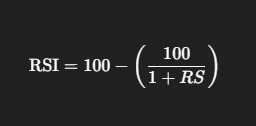

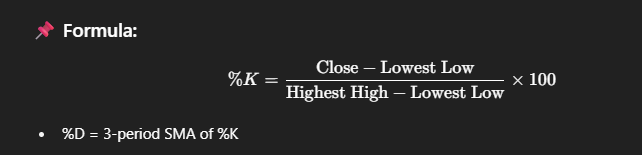

In [6]:
# Technical Analysis
# EMA
df['ema_13'] = df['close'].ewm(span=13, adjust=False).mean()
df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()

# # RSI
# window = 14 # default setting
# delta = df['close'].diff(1)
# avg_gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()  # avg_gain 
# avg_loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
# rsi = avg_gain / avg_loss
# df['rsi'] = 100 - (100 / (1 + rsi)) 

# Stochastic
perc_k_length = 5
perc_k_smoothing = 3
perc_d_length = 3

lowest_low = df['low'].rolling(perc_k_length).min()
highest_high = df['high'].rolling(perc_k_length).max()
df["stochastic_%K"] = ((df['close'] -lowest_low) / (highest_high -lowest_low)).rolling(perc_k_smoothing).mean() 
df["stochastic_%D"] =  df["stochastic_%K"].rolling(perc_d_length).mean()

# MACD
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()

macd = ema_12 - ema_26
macd_signal_line = macd.ewm(span=9, adjust=False).mean()
macd_bar = macd - macd_signal_line

df['macd'] = macd
df['macd_signal_line'] = macd_signal_line
df['macd_bar'] = macd_bar

In [7]:
df[df['date'] >= '2025-05-01']

,date,pair,open,high,low,close,volume,count,ema_13,ema_21,stochastic_%K,stochastic_%D,macd,macd_signal_line,macd_bar
4224,2025-05-01,XXBTZUSD,95194.3,96332.0,92970.5,96209.5,32409.0,1596,92386.175399,90371.044909,0.847617,0.822733,3151.117114,2370.381022,780.736093
4225,2025-05-02,XXBTZUSD,96209.5,97407.8,95900.4,96970.5,32153.0,1234,93041.078914,90970.995372,0.882749,0.848867,3257.877345,2547.880286,709.997059
4226,2025-05-03,XXBTZUSD,96970.5,97885.0,95893.8,95939.9,27565.0,1050,93455.196212,91422.713974,0.823836,0.851401,3222.181488,2682.740527,539.440961
4227,2025-05-04,XXBTZUSD,95939.9,96521.4,95305.6,95440.1,18605.0,689,93738.753896,91787.930886,0.669905,0.792164,3117.624545,2769.717330,347.907215
4228,2025-05-05,XXBTZUSD,95440.1,95761.3,93570.1,94071.8,25761.0,936,93786.331911,91995.555351,0.443606,0.645782,2891.026091,2793.979083,97.047009
4229,2025-05-06,XXBTZUSD,94071.9,95173.9,93624.4,93728.2,25079.0,1136,93778.027352,92153.068501,0.254415,0.455975,2653.135837,2765.810434,-112.674596
4230,2025-05-07,XXBTZUSD,93728.2,97650.0,93398.5,97011.5,30304.0,1414,94239.952016,92594.744091,0.355346,0.351122,2698.435087,2752.335364,-53.900277
4231,2025-05-08,XXBTZUSD,97011.5,99823.4,95824.0,99435.9,39783.0,1795,94982.230299,93216.667356,0.593878,0.401213,2896.573986,2781.183089,115.390897
4232,2025-05-09,XXBTZUSD,99433.1,104319.1,99099.0,102976.7,48656.0,2539,96124.297399,94103.943051,0.874023,0.607749,3301.258605,2885.198192,416.060413
4233,2025-05-10,XXBTZUSD,102976.8,104013.0,102344.7,103430.8,26748.0,952,97168.083485,94951.839137,0.911807,0.793236,3616.922524,3031.543058,585.379466


In [8]:
df[df['date'] >= '2025-05-01']

,date,pair,open,high,low,close,volume,count,ema_13,ema_21,stochastic_%K,stochastic_%D,macd,macd_signal_line,macd_bar
4224,2025-05-01,XXBTZUSD,95194.3,96332.0,92970.5,96209.5,32409.0,1596,92386.175399,90371.044909,0.847617,0.822733,3151.117114,2370.381022,780.736093
4225,2025-05-02,XXBTZUSD,96209.5,97407.8,95900.4,96970.5,32153.0,1234,93041.078914,90970.995372,0.882749,0.848867,3257.877345,2547.880286,709.997059
4226,2025-05-03,XXBTZUSD,96970.5,97885.0,95893.8,95939.9,27565.0,1050,93455.196212,91422.713974,0.823836,0.851401,3222.181488,2682.740527,539.440961
4227,2025-05-04,XXBTZUSD,95939.9,96521.4,95305.6,95440.1,18605.0,689,93738.753896,91787.930886,0.669905,0.792164,3117.624545,2769.717330,347.907215
4228,2025-05-05,XXBTZUSD,95440.1,95761.3,93570.1,94071.8,25761.0,936,93786.331911,91995.555351,0.443606,0.645782,2891.026091,2793.979083,97.047009
4229,2025-05-06,XXBTZUSD,94071.9,95173.9,93624.4,93728.2,25079.0,1136,93778.027352,92153.068501,0.254415,0.455975,2653.135837,2765.810434,-112.674596
4230,2025-05-07,XXBTZUSD,93728.2,97650.0,93398.5,97011.5,30304.0,1414,94239.952016,92594.744091,0.355346,0.351122,2698.435087,2752.335364,-53.900277
4231,2025-05-08,XXBTZUSD,97011.5,99823.4,95824.0,99435.9,39783.0,1795,94982.230299,93216.667356,0.593878,0.401213,2896.573986,2781.183089,115.390897
4232,2025-05-09,XXBTZUSD,99433.1,104319.1,99099.0,102976.7,48656.0,2539,96124.297399,94103.943051,0.874023,0.607749,3301.258605,2885.198192,416.060413
4233,2025-05-10,XXBTZUSD,102976.8,104013.0,102344.7,103430.8,26748.0,952,97168.083485,94951.839137,0.911807,0.793236,3616.922524,3031.543058,585.379466


## Technical Analysis

In [9]:
# Technical Analysis
# EMA
df['ema_13'] = df['close'].ewm(span=13, adjust=False).mean()
df['ema_21'] = df['close'].ewm(span=21, adjust=False).mean()

# Stochastic
window = 14 # default setting
perc_k_length = 5
perc_k_smoothing = 3
perc_d_length = 3

lowest_low = df['low'].rolling(window).min()
highest_high = df['high'].rolling(window).max()
df["stochastic_%K"] = ((df['close'] -lowest_low) / (highest_high -lowest_low)).rolling(perc_k_smoothing).mean() 
df["stochastic_%D"] =  df["stochastic_%K"].rolling(perc_d_length).mean()

# MACD
ema_12 = df['close'].ewm(span=12, adjust=False).mean()
ema_26 = df['close'].ewm(span=26, adjust=False).mean()

macd = ema_12 - ema_26
macd_signal_line = macd.ewm(span=9, adjust=False).mean()
macd_bar = macd - macd_signal_line

df['macd'] = macd
df['macd_signal_line'] = macd_signal_line
df['macd_bar'] = macd_bar

# LLM

In [6]:
from src.utils.timescaledb_ops import TimescaleDBOps
import pandas as pd
tsdb_ops = TimescaleDBOps()
columns, data = tsdb_ops.read_data("gold.ohlc_ta_weekly")
df = pd.DataFrame(data=data, columns=columns)
df = df.sort_values("date").reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

2025-06-27 17:20:03,226 - INFO - Data read from gold.ohlc_ta_weekly successfully.


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_visualize = df[df['date'] >= '2024-01-01']

# Create subplot with 2 rows (OHLC and Volume)
fig = make_subplots(rows=4, cols=1, 
                    shared_xaxes=True, 
                    vertical_spacing=0.02,
                    row_heights=[0.6, 0.1, 0.15, 0.15],
                    subplot_titles=("OHLC BTC (USD)", "Volume", "Stochastic(5, 3, 4)", "MACD(12, 26, 9)"))

# ===================================================================
# PLOT CANDLESTICK
# ===================================================================
fig.add_trace(go.Candlestick(
    x=df_visualize['date'],
    open=df_visualize['open'],
    high=df_visualize['high'],
    low=df_visualize['low'],
    close=df_visualize['close'],
    name="Price",
    increasing_line_color='green',
    decreasing_line_color='red'
), row=1, col=1)


# ===================================================================
# PLOT VOLUME BAR
# ===================================================================
fig.add_trace(go.Bar(
    x=df_visualize['date'],
    y=df_visualize['volume'],
    name="Volume",
    marker_color='orange'
), row=2, col=1)


# ===================================================================
# PLOT EMA
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['ema_13'],
        mode='lines',
        name="EMA 13",
        line={'width': 1.5},
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['ema_21'],
        mode='lines',
        name="EMA 21",
        line={'width': 1.5},
    ), row=1, col=1
)

# ===================================================================
# PLOT STOCHASTIC
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['stochastic_percentage_k'],
        mode='lines',
        name="Stochastic",
        line={'width': 1.5},
    ), row=3, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['stochastic_percentage_d'],
        mode='lines',
        name="Stochastic",
        line={'width': 1.5},
    ), row=3, col=1
)

# ===================================================================
# PLOT MACD
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['macd'],
        mode='lines',
        name="MACD Line",
        line={'width': 1.5},
    ), row=4, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['macd_signal_line'],
        mode='lines',
        name="MACD Signal Line",
        line={'width': 1.5},
    ), row=4, col=1
)

colors = ['green' if val >= 0 else 'red' for val in df_visualize['macd_bar']]
fig.add_trace(
    go.Bar(
        x=df_visualize['date'], 
        y=df_visualize['macd_bar'], 
        name='MACD Bar', 
        marker_color=colors
    ), row=4, col=1
)

# Layout adjustments
fig.update_layout(
    # title=title,
    xaxis_rangeslider_visible=False,
    template='plotly_dark',
    height=1000,
    margin=dict(l=50, r=25, t=50, b=40)
)

fig.write_image("btc_monthly_ta.jpeg", width=1200, height=800, scale=2)

In [17]:
df.columns.tolist()
# df.values.tolist()

['date',
 'pair',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'count',
 'ema_13',
 'ema_21',
 'stochastic_percentage_k',
 'stochastic_percentage_d',
 'macd',
 'macd_signal_line',
 'macd_bar']

In [57]:
import anthropic
import os
import base64
from dotenv import load_dotenv

load_dotenv()
client = anthropic.Anthropic(
    # defaults to os.environ.get("ANTHROPIC_API_KEY")
    api_key=os.environ.get("ANTHROPIC_API_KEY"),
)

# Replace placeholders like {{CRYPTOCURRENCY}} with real values,
# because the SDK does not support variables.
ticker = "BTC-USD"
granularity = "daily"
def get_base64_encoded_image(image_path):
    with open(image_path, "rb") as image_file:
        binary_data = image_file.read()
        base64_encoded_data = base64.b64encode(binary_data)
        base64_string = base64_encoded_data.decode("utf-8")
        return base64_string

messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": "image/jpeg",
                        "data": get_base64_encoded_image("btc_monthly_ta.jpeg")
                    }
                },
                {
                    "type": "text",
                    "text": f"""
                        You are a professional trader at a top proprietary trading firm, specializing in cryptocurrency and technical analysis. 
                        Your task is to analyze the {granularity} chart and technical indicators for {ticker} based on the provided image.
                        Perform a comprehensive analysis based on recent chart, candlestick patterns, overall trend, and various technical indicators. 
                        Your analysis should lead to a recommendation for action.
                        Based on your analysis, recommend one of the following actions:
                        1. 'weak sell'
                        2. 'sell'
                        3. 'strong sell'
                        4. 'weak buy'
                        5. 'buy'
                        6. 'strong buy'
                        
                        For the output, you should only follow this structure:
                        {{
                            \"action\": \"[Your recommended action]\",    
                            \"reason\": {{
                                    \"ema\": \"[EMA analysis summary]\",
                                    \"stochastic\": \"[Stochastic oscillator analysis summary]\",
                                    \"macd\": \"[MACD analysis summary]\",
                                    \"trend\": \"[Overall trend analysis summary]\",
                                    \"pattern\": \"[Candlestick pattern analysis summary]\",
                                    \"volume\": \"[Volume analysis summary]\"
                            }}
                        }}
                        Important rule: Just return the raw JSON text in the body of the response.
                    """
                }
            ]
        },
    ]

llm_output = client.messages.create(
    model="claude-sonnet-4-20250514",
    max_tokens=20000,
    temperature=1,
    messages=messages
)

In [58]:
print(llm_output.content[0].text)

{
    "action": "weak buy",
    "reason": {
        "ema": "Price is trading above both EMA 13 and EMA 21, with EMA 13 crossing above EMA 21, indicating bullish momentum. The EMAs are providing dynamic support around the 95k-98k level.",
        "stochastic": "Stochastic oscillator is declining from overbought territory and currently around 0.4-0.5 range, suggesting some cooling off from previous highs but not yet oversold, providing potential entry opportunity.",
        "macd": "MACD shows negative histogram bars (red) with the MACD line below the signal line, indicating short-term bearish momentum, but the lines appear to be converging which could signal potential reversal.",
        "trend": "Overall uptrend remains intact with higher highs and higher lows pattern. Price has retraced from recent highs around 110k to current levels near 105k, which appears to be a healthy pullback in the broader uptrend.",
        "pattern": "Recent candlesticks show consolidation with some red cand

In [83]:
import json
message = json.loads(llm_output.content[0].text)

summary = ""
summary += f"Action: **{message['action'].capitalize()}**\n"
for num, (indicator, explanation) in enumerate(message['reason'].items()):
    summary += f"{num+1}. **{indicator.upper()}**: {explanation}.\n"
summary += "*^Disclaimer Alert.*"

# Send to Discord Channel

In [89]:
import requests

webhook_url = "https://discordapp.com/api/webhooks/1387080438140637184/tN2QiS7fsMTOpf9eHQAF8cb2xfAscck9R6qhKq-hvvg4Ssg0YfHsSXvGIDLZUchoFQ6V"
granularity = "Weekly"

embed = {
    "title": f"**Bitcoin (BTC-USD) {granularity.capitalize()} Summary**",
    "image": {"url": "attachment://btc_monthly_ta.jpeg"},
    "description": summary,
    "color": 5814783  # optional: light blue
}
data = {
    "content": (
        f"**Bitcoin (BTC-USD) {granularity.capitalize()} Summary**\n\n"
        f"{summary}"
    )
}


files = {
    "file": (
        "btc_monthly_ta.jpeg", 
        open("C:/Users/USER/projects/ai-agent-crypto-analyzer/notebooks/btc_monthly_ta.jpeg", "rb")
    )
}

# Use `data=` for data when uploading files
response = requests.post(webhook_url, files=files, data=data)

# Using Langchain Anthropic

In [2]:
# Import Credentials
import os
import getpass
from dotenv import load_dotenv

load_dotenv()
if "ANTHROPIC_API_KEY" not in os.environ:
    os.environ["anthropic_api_key"] = getpass.getpass("Enter your ANTHROPIC_API_KEY: ")


In [1]:
# Get Anthropic LLM Model
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(
    model="claude-sonnet-4-20250514",
    max_tokens=20000,
    temperature=0.5,
    timeout=None,
    max_retries=2
)

# Construct the prompt
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate(
    [
        {
            "role": "system", 
            "content": [
                {
                    "type": "text",
                    "text": "You are a professional cryptocurrency trader at a top proprietary trading firm, specializing in technical analysis."
                }
            ]
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source_type": "base64",
                    "mime_type": "image/png",
                    "data": "{image_base64}",
                },
                {
                    "type": "text",
                    "text": """
                    Your task is to analyze the {timeframe} chart and technical indicators for {ticker} based on the provided image.
                    Perform a technical analysis based on candlestick charts, volume, and technical indicators like {technical_indicators} (shown in image). 
                    Your technical analysis should lead to a recommendation one of the following actions:
                    <actions>
                        1. 'Weak Sell'
                        2. 'Sell'
                        3. 'Strong Sell'
                        4. 'Weak Buy'
                        5. 'Buy'
                        6. 'Strong Buy'
                    </actions>
                    For the prompt output, it should only formatted like in the <structure> tags below. Do not inlcude markdown texts. 
                    <structure>
                        {{
                            \"action\": \"Your recommended action based on the <actions> tags\",    
                            \"reason\": {{
                                \"ema\": \"EMA analysis\",
                                \"stochastic\": \"Stochastic oscillator analysis\",
                                \"macd\": \"MACD analysis\",
                                \"trend\": \"Overall trend analysis\",
                                \"pattern\": \"Candlestick pattern analysis\",
                                \"volume\": \"Volume analysis\"
                            }}
                        }}
                    </structure>
                    """
                }
            ]
        }
    ]
)

chain = prompt | llm

In [ ]:
# Get data from database
from src.utils.timescaledb_ops import TimescaleDBOps
import pandas as pd
import base64
# Variables
granularity = "monthly"
ticker = "BTC/USD"
technical_indicators = "EMA, Stochastic, MACD"

tsdb_ops = TimescaleDBOps()
columns, data = tsdb_ops.read_data(f"gold.ohlc_ta_{granularity}")
df = pd.DataFrame(data=data, columns=columns)
df = df.sort_values("date").reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])

# Construct the image base64 string
# 1. Create png image
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df_visualize = df[df['date'] >= '2022-01-01']

# Create subplot with 2 rows (OHLC and Volume)
fig = make_subplots(rows=4, cols=1, 
                    shared_xaxes=True, 
                    vertical_spacing=0.02,
                    row_heights=[0.6, 0.1, 0.15, 0.15],
                    subplot_titles=("OHLC BTC (USD)", "Volume", "Stochastic(5, 3, 4)", "MACD(12, 26, 9)"))

# ===================================================================
# PLOT CANDLESTICK
# ===================================================================
fig.add_trace(go.Candlestick(
    x=df_visualize['date'],
    open=df_visualize['open'],
    high=df_visualize['high'],
    low=df_visualize['low'],
    close=df_visualize['close'],
    name="Price",
    increasing_line_color='green',
    decreasing_line_color='red'
), row=1, col=1)


# ===================================================================
# PLOT VOLUME BAR
# ===================================================================
fig.add_trace(go.Bar(
    x=df_visualize['date'],
    y=df_visualize['volume'],
    name="Volume",
    marker_color='orange'
), row=2, col=1)


# ===================================================================
# PLOT EMA
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['ema_13'],
        mode='lines',
        name="EMA 13",
        line={'width': 1.5},
    ), row=1, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['ema_21'],
        mode='lines',
        name="EMA 21",
        line={'width': 1.5},
    ), row=1, col=1
)

# ===================================================================
# PLOT STOCHASTIC
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['stochastic_percentage_k'],
        mode='lines',
        name="Stochastic",
        line={'width': 1.5},
    ), row=3, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['stochastic_percentage_d'],
        mode='lines',
        name="Stochastic",
        line={'width': 1.5},
    ), row=3, col=1
)

# ===================================================================
# PLOT MACD
# ===================================================================
fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['macd'],
        mode='lines',
        name="MACD Line",
        line={'width': 1.5},
    ), row=4, col=1
)

fig.add_trace(
    go.Scatter(
        x=df_visualize['date'],
        y=df_visualize['macd_signal_line'],
        mode='lines',
        name="MACD Signal Line",
        line={'width': 1.5},
    ), row=4, col=1
)

colors = ['green' if val >= 0 else 'red' for val in df_visualize['macd_bar']]
fig.add_trace(
    go.Bar(
        x=df_visualize['date'], 
        y=df_visualize['macd_bar'], 
        name='MACD Bar', 
        marker_color=colors
    ), row=4, col=1
)

# Layout adjustments
fig.update_layout(
    # title=title,
    xaxis_rangeslider_visible=False,
    template='plotly_dark',
    height=1000,
    margin=dict(l=50, r=25, t=50, b=40)
)

fig.write_image(f"btc_{granularity}_ta.png", width=1200, height=800, scale=2)

2025-06-27 18:06:48,341 - INFO - Data read from gold.ohlc_ta_monthly successfully.
INFO	ai-agent-crypto-analyzer:timescaledb_ops.py:read_data()- Data read from gold.ohlc_ta_monthly successfully.


In [ ]:
import base64
def get_base64_encoded_image(image_path):
    with open(image_path, "rb") as image_file:
        binary_data = image_file.read()
        base64_encoded_data = base64.b64encode(binary_data)
        base64_string = base64_encoded_data.decode("utf-8")
        return base64_string

granularity = "monthly"
ticker = "BTC/USD"
technical_indicators = "EMA, Stochastic, MACD"
image_base64 = get_base64_encoded_image("btc_{granularity}_ta.png".format(granularity=granularity))

In [ ]:
# prompt.format_messages(
#     image_base64= image_base64,
#     ticker= ticker,
#     timeframe= granularity,
#     technical_indicators= technical_indicators
# )
# for message in prompt.format_messages(
#         image_base64= image_base64,
#         ticker= ticker,
#         timeframe= granularity,
#         technical_indicators= technical_indicators
#     ):
#     for content in message.content:
#         print(content["type"])
#         if content["type"] == "text":
#             print(content["text"])
#         if content["type"] == "image":
#             print(content["data"])
    
#         # elif content["type"] == "imageThe line `print(f"Image URL: {content["data"]}")` is attempting to print out the URL of an image contained in the `content` dictionary. The `content` dictionary likely has a key named "data" which holds the URL of the image.
#         # ":
#         #     print(f"Image URL: {content["data"]}")

text
You are a professional cryptocurrency trader at a top proprietary trading firm, specializing in technical analysis.
image
iVBORw0KGgoAAAANSUhEUgAACWAAAAZACAYAAAD9qXmxAAAAAXNSR0IArs4c6QAAIABJREFUeF7s3Xm4VWXZP/CbUTEGraxEy8zZNId6G5zNnMoBRBxyQM0JFUWUScARRJwNFRUjVAxNBRwqE3HWHDLf0lIxh9S01MLhICDT71rb3+E9HA6cvffZ56x11v7s63qv9/d61nqe+/7cD3/9vtez2qy22mqLw48AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEShZoI4BVspkXCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUBAQwHIQCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUKaAAFaZcF4jQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQICAAJYzQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgTIFBLDKhPMaAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIEBLCcAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECJQpIIBVJpzXCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgIIDlDBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKBMAQGsMuG8RoAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQEsZ4AAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAA

In [21]:
response = chain.invoke(
    {
        "image_base64": image_base64,
        "ticker": ticker,
        "timeframe": granularity,
        "technical_indicators": technical_indicators
    }
)

In [22]:
print(response.content)

{
    "action": "Weak Buy",
    "reason": {
        "ema": "Price is trading above both EMA 13 and EMA 21, indicating bullish momentum. The EMAs are sloping upward and price has maintained support above these moving averages, suggesting the uptrend remains intact despite recent consolidation.",
        "stochastic": "Stochastic oscillator is in neutral territory around 0.6 level, having pulled back from overbought conditions. This provides room for upward movement without being oversold, indicating potential for continued bullish momentum.",
        "macd": "MACD line remains above the signal line with positive histogram bars, confirming bullish momentum. The MACD has been trending higher throughout the uptrend, though showing some recent consolidation which is healthy for trend continuation.",
        "trend": "Strong uptrend from the low around 15k to current levels above 100k. The trend structure shows higher highs and higher lows with price respecting key moving average support lev

In [25]:
import json
message = json.loads(response.content)

summary = ""
summary += f"Action: **{message['action'].capitalize()}**\n"
for num, (indicator, explanation) in enumerate(message['reason'].items()):
    summary += f"{num+1}. **{indicator.upper()}**: {explanation}.\n"
summary += "*^Disclaimer Alert.*"

In [26]:
summary

'Action: **Weak buy**\n1. **EMA**: Price is trading above both EMA 13 and EMA 21, indicating bullish momentum. The EMAs are sloping upward and price has maintained support above these moving averages, suggesting the uptrend remains intact despite recent consolidation..\n2. **STOCHASTIC**: Stochastic oscillator is in neutral territory around 0.6 level, having pulled back from overbought conditions. This provides room for upward movement without being oversold, indicating potential for continued bullish momentum..\n3. **MACD**: MACD line remains above the signal line with positive histogram bars, confirming bullish momentum. The MACD has been trending higher throughout the uptrend, though showing some recent consolidation which is healthy for trend continuation..\n4. **TREND**: Strong uptrend from the low around 15k to current levels above 100k. The trend structure shows higher highs and higher lows with price respecting key moving average support levels. Recent consolidation appears to 

In [27]:
import requests

webhook_url = "https://discordapp.com/api/webhooks/1387080438140637184/tN2QiS7fsMTOpf9eHQAF8cb2xfAscck9R6qhKq-hvvg4Ssg0YfHsSXvGIDLZUchoFQ6V"
granularity = "Weekly"

embed = {
    "title": f"**Bitcoin (BTC-USD) {granularity.capitalize()} Summary**",
    "image": {"url": "attachment://btc_monthly_ta.jpeg"},
    "description": summary,
    "color": 5814783  # optional: light blue
}
data = {
    "content": (
        f"**Bitcoin (BTC-USD) {granularity.capitalize()} Summary**\n\n"
        f"{summary}"
    )
}


files = {
    "file": (
        "btc_monthly_ta.jpeg", 
        open("C:/Users/USER/projects/ai-agent-crypto-analyzer/notebooks/btc_monthly_ta.jpeg", "rb")
    )
}

# Use `data=` for data when uploading files
requests.post(webhook_url, files=files, data=data)

<Response [200]>